##Importación de librerías necesarias

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UD3kmeans/Mall_Customers.csv")

In [ ]:
df.head().T

,0,1,2,3,4
CustomerID,1,2,3,4,5
Gender,Male,Male,Female,Female,Female
Age,19,21,20,23,31
Annual Income (k$),15,15,16,16,17
Spending Score (1-100),39,81,6,77,40


##Preprocesamiento y elección de variables relevantes para el estudio.

Eliminacion de la columna CustomerID, ya que no aporta mucha relevancia

In [ ]:
df.drop(["CustomerID"], axis = 1, inplace=True)

In [ ]:
df.head().T

,0,1,2,3,4
Gender,Male,Male,Female,Female,Female
Age,19,21,20,23,31
Annual Income (k$),15,15,16,16,17
Spending Score (1-100),39,81,6,77,40


Filtrado de nulos

In [ ]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [ ]:
# df= df.dropna(how='any')

In [ ]:
df

Conversion del dataframe to numpy array

Solo nos quedamos con las columnas Spending Score (1-100) y Annual Income (k$)

In [ ]:
df_X = df[['Annual Income (k$)','Spending Score (1-100)']]

In [ ]:
df_X

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [ ]:
df_x = df_X.to_numpy()

In [ ]:
X = df_x

In [ ]:
# X

## Detección del número de clusters

Por tratarse de un caso real el número de clusters $K$ es desconocido. Vamos a aplicar  el criterio basado en el BIC para el cálculo de este hiperparámetro, para ello haremos uso de la función *BIC* (previamente empleada en el Ejemplo 6.1).  

Tras ejecutar el siguiente código podemos observar que el BIC decrece hasta $K=5$ y luego crece de nuevo. Por lo tanto $K=5$ será el valor elegido.

In [ ]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

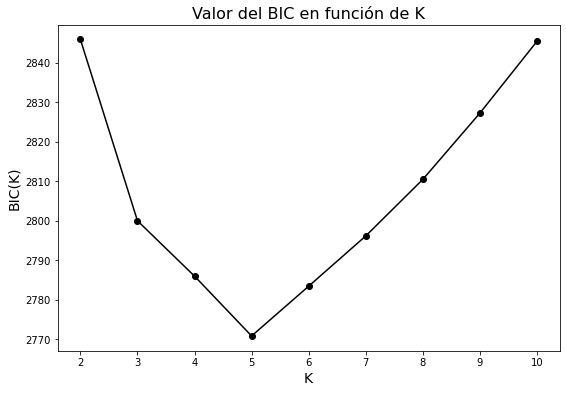

In [ ]:
## Calculo del BIC
Kmax = 10
BIC_array = []
for k in range(2, Kmax+1):
  kmeans = KMeans(n_clusters=k, n_init=15, random_state=100)
  grupos = kmeans.fit_predict(X)
  BIC_array.append(BIC(k, grupos, X))

# Dibujamos el BIC obtenido para cada valor de k
plt.figure(figsize=(9, 6))
plt.plot(np.arange(2, Kmax+1), BIC_array, "ko-")
plt.title("Valor del BIC en función de K", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.show()

## Detección de outliers (anomalías)

Vamos a aplicar el método de Jackknife para detectar las observaciones influyentes.  El siguiente código detecta los outliers y los elimina del análisis y los representa visualmente. Notar que si el número de réplicas en el número de veces que se realiza el algoritmo de las k-medias es pequeño el procedimiento detecta diferentes conjunto de outliers ya que llega a diferentes soluciones. Hemos fijado este valor a $30$.

In [ ]:
## Detección de outliers
N = X.shape[0] # Número de observaciones
K = 5 # Número de clusters el que se ve en el grafico

SSE = []
for i in range(0, N):
  X_sin_i = np.delete(X, i, axis=0) # Eliminamos la observación i
  # Aplicamos K-medias a X_sin_i y obtenemos el índice SSE
  kmeans = KMeans(n_clusters=K, n_init=30, random_state=100).fit(X_sin_i)
  SSE.append(kmeans.inertia_)

In [ ]:
min(SSE)

41834.29890272454

In [ ]:
max(SSE)

44444.53183682259

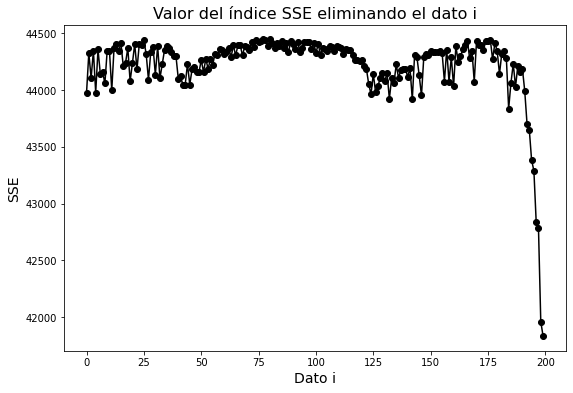

In [ ]:
## Detección visual de outliers
# Dibujamos el SSE obtenido eliminando cada observación
plt.figure(figsize=(9, 6))
plt.plot(np.arange(0, N), SSE, "ko-")
plt.title("Valor del índice SSE eliminando el dato i", fontsize=16)
plt.xlabel("Dato i", fontsize=14)
plt.ylabel("SSE", fontsize=14)
plt.show()

In [ ]:
## Detección analítica de outliers
sigma = np.std(SSE) # Desviación típica de SSE
mu = np.mean(SSE) # Media
umbral = 2 # Umbral: 2 para distribuciones normales y 3 para cualquier otra distribución

outliers = []
for i in range(0, N):
  if np.abs(SSE[i]-mu) > umbral*sigma:
    outliers.append(i)
print(outliers)

[194, 195, 196, 197, 198, 199]


In [ ]:
## Eliminación de los outliers
X_new = np.delete(X, outliers, axis=0)
X_new.shape

(194, 2)

In [ ]:
df = df.drop(outliers,axis=0)

## Determinación de patrones y estudio

Finalmente calculamos los patrones mediante el algoritmo $K-$means, los repesentamos gráficamente

In [ ]:
## Cálculo de patrones
kmeans = KMeans(n_clusters=K, n_init=30, random_state=100)
pred = kmeans.fit_predict(X_new)
centroides = kmeans.cluster_centers_

In [ ]:
centroides

array([[26.30434783, 20.91304348],
       [54.61538462, 50.02564103],
       [25.72727273, 79.36363636],
       [83.51428571, 18.45714286],
       [83.11111111, 82.41666667]])

In [ ]:
centroides[0][0]

26.30434782608694

In [ ]:
df["label"] = pred

In [ ]:
df.head().T

,0,1,2,3,4
CustomerID,1,2,3,4,5
Gender,Male,Male,Female,Female,Female
Age,19,21,20,23,31
Annual Income (k$),15,15,16,16,17
Spending Score (1-100),39,81,6,77,40
label,0,2,0,2,0


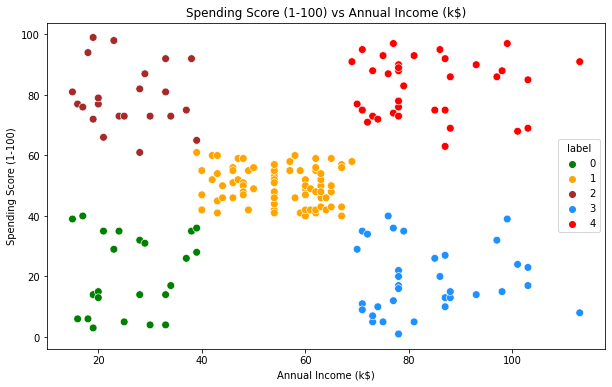

In [ ]:
#Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Annual Income (k$)',y = 'Spending Score (1-100)',hue="label",  
                 palette=['green','orange','brown','dodgerblue','red'], legend='full',data = df  ,s = 60 )
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)') 
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.show()

In [ ]:
N_patron = np.bincount(pred) # Contar el número veces del label que se repite 
tabla = pd.DataFrame(columns=["Número de grupo", "Número de observaciones del grupo","Mean Age",
                              "Centroide:característica Annual Income (k$)",
                              "Centroide :caracteristica Spending Score (1-100)"])

for k in range(K):
  tabla.loc[k, "Número de grupo"] = k
  tabla.loc[k, "Número de observaciones del grupo"] = N_patron[k]  
  # tabla.loc[k,"Gender"] = df["Gender"]
  tabla.loc[k, "Mean Age"] = np.mean(df["Age"][df["label"] == k])
  tabla.loc[k, "Centroide:característica Annual Income (k$)"] = centroides[k][0]
  tabla.loc[k, "Centroide :caracteristica Spending Score (1-100)"] = centroides[k][1]
    

# Mostrar la tabla
display(tabla)

,Número de grupo,Número de observaciones del grupo,Mean Age,Centroide:característica Annual Income (k$),Centroide :caracteristica Spending Score (1-100)
0,0,23,45.217391,26.304348,20.913043
1,1,78,43.128205,54.615385,50.025641
2,2,22,25.272727,25.727273,79.363636
3,3,35,40.314286,83.514286,18.457143
4,4,36,32.722222,83.111111,82.416667
